In [1]:
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from DS_Planck_Unet import west_val, east_val
from matplotlib import pyplot as plt
import os
from tqdm.notebook import tqdm
from DS_data_transformation import this_ax
from DS_models_stat import b20_coef

In [2]:
max_pred_unite = np.arange(0.1, 1, 0.05)
max_found_val = 250

In [3]:
def change_names(name):
    if name == 'eb20':
        return ''
    if name in ['41', '6', '38']:
        return 'area ' + name
    if name == 'all_true':
        return 'PSZ2(z)+MCXC+ACT'
    return name

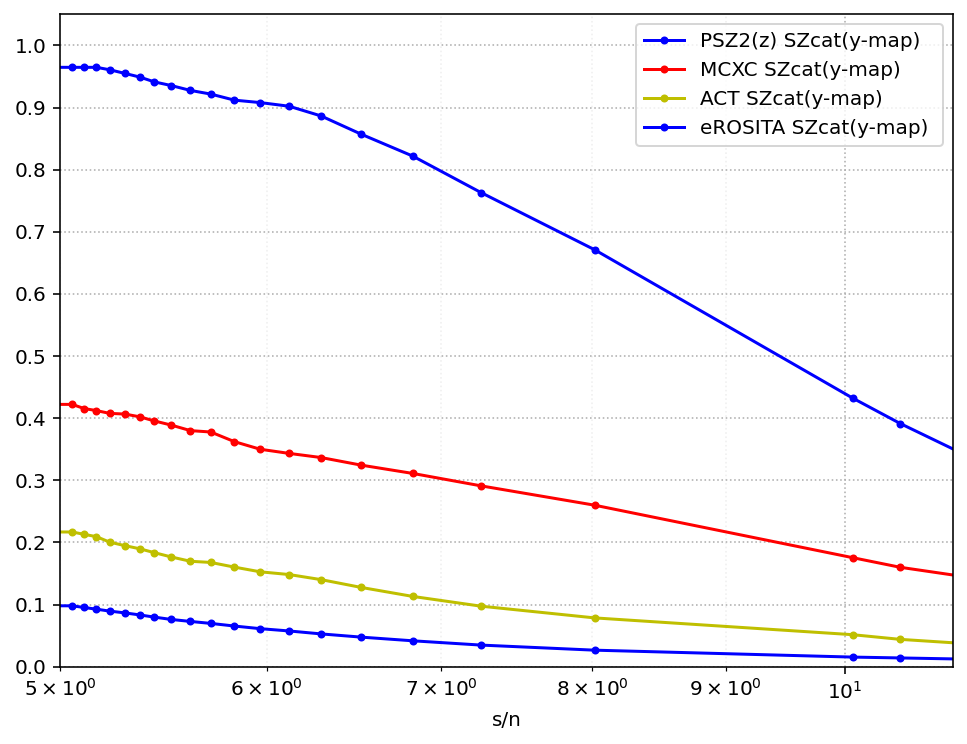

In [4]:
def show_prm(ax, pixname, selected_det, selected_tr, index_name='auto', ylabel='', xlim=[0, 1], xticks=None,
            only_plot=False, colors='brycg', found_mode=False, coef=1.0, xlog=False, ylog=False, 
             fylim=[0, 200], fyticks=[0, 200, 50], xlabel=None):
    #cats = ['SZcat(base)',  'SZcat(AL)', 'SZcat(y-map)', 'gen', 'SZcat(AL)_unique', 'inter', 'SZcat(y-map)_unique']
    index_auto = {
        'SZcat(base)' : 'max_pred',
        'SZcat(AL)' : 'max_pred',
        'SZcat(y-map)' : 's/n', 
        'SZcat(gen)' : 'mpp_er', 
        'SZcat(AL)_unique' : 'max_pred', 
        'inter' : 'max_pred',
        'inter_sn' : 's/n',
        'SZcat(AL)_unique' : 'max_pred'
    }
    if index_name == 'auto':
        index_name = index_auto[selected_det[0]]
        
    recalls = {name : pd.read_csv('./check/{}_recall_{}_pix{}.csv'.format(name, index_name.replace('/', ''), pixname), 
                                  index_col=index_name)
                  for name in selected_det}

    for c, name_tr in zip(colors, selected_tr):
        for name_det, st in zip(recalls, ['-', '--']):
            df = recalls[name_det]
            s, = ax.plot(df.index, df[name_tr] * coef, c=c, linestyle=st, marker='o', markersize=3)
            s.set_label(change_names(name_tr) + ' ' + name_det + ' ' + change_names(pixname))
    if not only_plot:
        ax.set_ylabel(ylabel)
        if xlabel is None:
            xlabel = index_name
        ax.set_xlabel(xlabel)

        if xticks is None:
            xticks = df.index
        if selected_det[0] == 'SZcat(AL)':
            ax.set_xticks(xticks[::2], minor=False)
        else:
            ax.set_xticks(xticks, minor=False)
            
        ax.set_xlim(xlim)
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log')
        
        if not found_mode:
            ax.set_yticks(np.arange(0, 1.1, 0.1), minor=False)
            ax.set_ylim(0, 1.05)
        else:
            ax.set_yticks(np.arange(*fyticks))
            ax.set_ylim(*fylim)

        ax.grid(True, axis='both', which='major', linestyle=':')
        ax.grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
        ax.legend()

_, ax = plt.subplots(1, 1, figsize=(8, 6))
#show_prm(ax, '41', selected_det=['SZcat(AL)'], selected_tr=['PSZ2(z)', 'MCXC', 'ACT'],
#           index_name='max_pred', xlim=[0.1, 1.0], xlog=False)
#show_prm(ax, 'e', selected_det=['gen'], selected_tr=['PSZ2(z)', 'MCXC', 'ACT', 'Abell', 'eROSITA'],
#           index_name='mpp', dirname='./check/', xlim=[0.3, 1])
show_prm(ax, 'eb20', selected_det=['SZcat(y-map)'], selected_tr=['PSZ2(z)', 'MCXC', 'ACT'],
        index_name='s/n', xlog=True, xlim=[5, 11], only_plot=True)
show_prm(ax, 'eb20', selected_det=['SZcat(y-map)'], selected_tr=['eROSITA'],
        index_name='s/n', xlog=True, xlim=[5, 11])

In [54]:
def show_fraction(ax, catname, index_name, index_vals, color='r', linest='-'):
    df_dict = {'SZcat(AL)' : pd.read_csv('/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn_mpp.csv'),
           'SZcat(gen)' : pd.read_csv('/home/rt2122/Data/gen_cats/gen_all_found_brcat_prec0.00.csv')}
    df = df_dict[catname]
    fraction = []
    for val in index_vals:
        fraction.append(np.count_nonzero(df[index_name] >= val) / len(df))
    s, = ax.plot(index_vals, fraction, color=color, linestyle=linest)
    s.set_label(catname + ' fraction')
    return fraction

def show_new_obj(ax, fraction, catname, index_name, pixname, index_vals, prec_cat, color='r', linest='-'):
    
    filename = './check/{}_recall_{}_pix{}.csv'.format(catname, index_name, pixname)
    df = pd.read_csv(filename)
    new_obj = fraction * (df['precision'] - df['precision_' + prec_cat])
    s, = ax.plot(index_vals, new_obj, color=color, linestyle=linest)
    s.set_label(catname + ' new obj ' + pixname + ' ' + prec_cat)

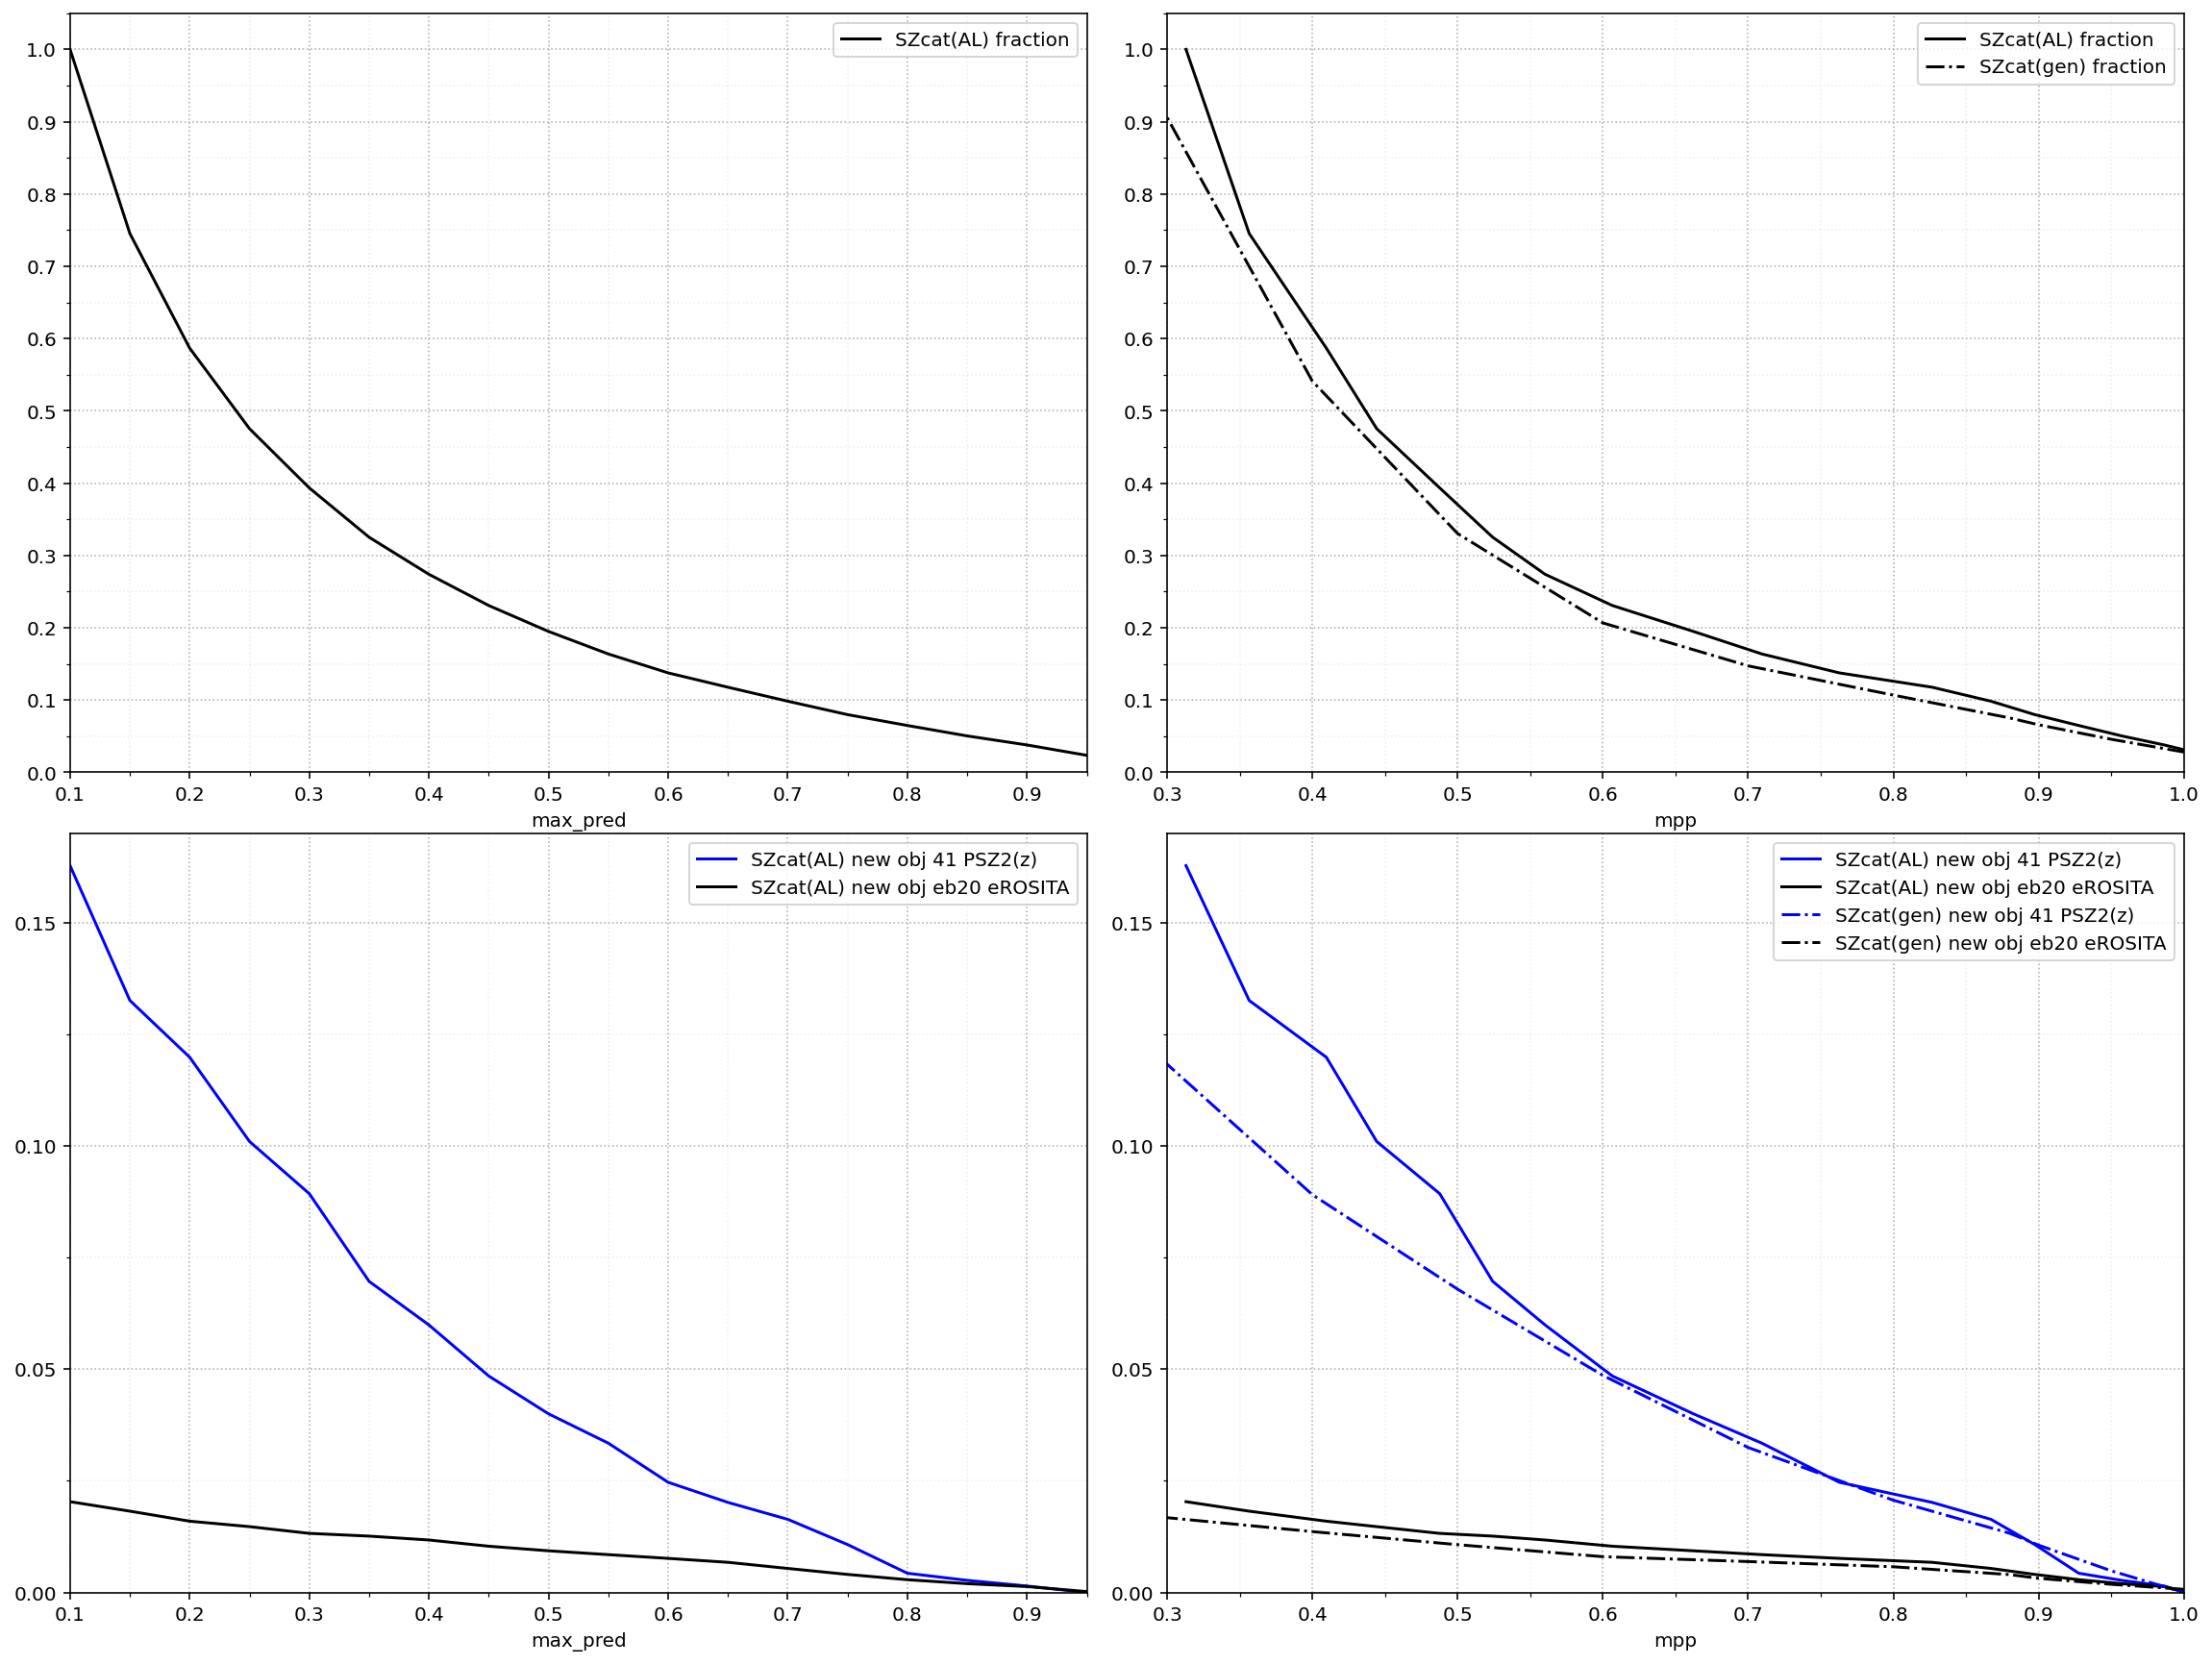

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(8 * 2, 6 * 2))
fig.tight_layout()
det_names_list = [['SZcat(AL)'], ['SZcat(AL)', 'SZcat(gen)']]
index_names_list = ['max_pred', 'mpp']
for i, det_names, index_name in zip([0, 1], det_names_list, index_names_list):
    for name, linest in zip(det_names, ['-', 'dashdot']):
        vals = pd.read_csv('./check/{}_recall_{}_pix{}.csv'.format(name, index_name, pixname))[index_name]
        fraction = show_fraction(ax[0][i], name, index_name, vals, color=c, linest=linest)
        for true_cat, pixname, c in zip(['PSZ2(z)', 'eROSITA'], ['41', 'eb20'], 'bk'):
            show_new_obj(ax[1][i], fraction, name, index_name=index_name, index_vals=vals, 
                         pixname=pixname, prec_cat=true_cat, color=c, linest=linest)
    for j in range(2):
        ax[j][i].legend()
        ax[j][i].set_xlabel(index_name)
        ax[i][j].set_xticks(np.arange(0, 1.1, 0.1), minor=False)
        ax[i][j].set_xticks(np.arange(0, 1.1, 0.05), minor=True)
        ax[j][i].grid(True, axis='both', which='major', linestyle=':')
        ax[j][i].grid(True, axis='both', which='minor', alpha=0.2, linestyle=':')
        
for i in range(2):
    ax[0][i].set_ylim(0, 1.05)
    ax[0][i].set_yticks(np.arange(0, 1.1, 0.1), minor=False)
    ax[0][i].set_yticks(np.arange(0, 1.1, 0.05), minor=True)
    
    ax[1][i].set_ylim(0, 0.17)
    ax[1][i].set_yticks(np.arange(0, 0.17, 0.05), minor=False)
    ax[1][i].set_yticks(np.arange(0, 0.17, 0.025), minor=True)
    
    ax[i][0].set_xlim(0.1, 0.95)
    ax[i][1].set_xlim(0.3, 1)


<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)
<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)
<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)
<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)
<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)
<ipython-input-4-4c5c7126baf1>:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*fylim)


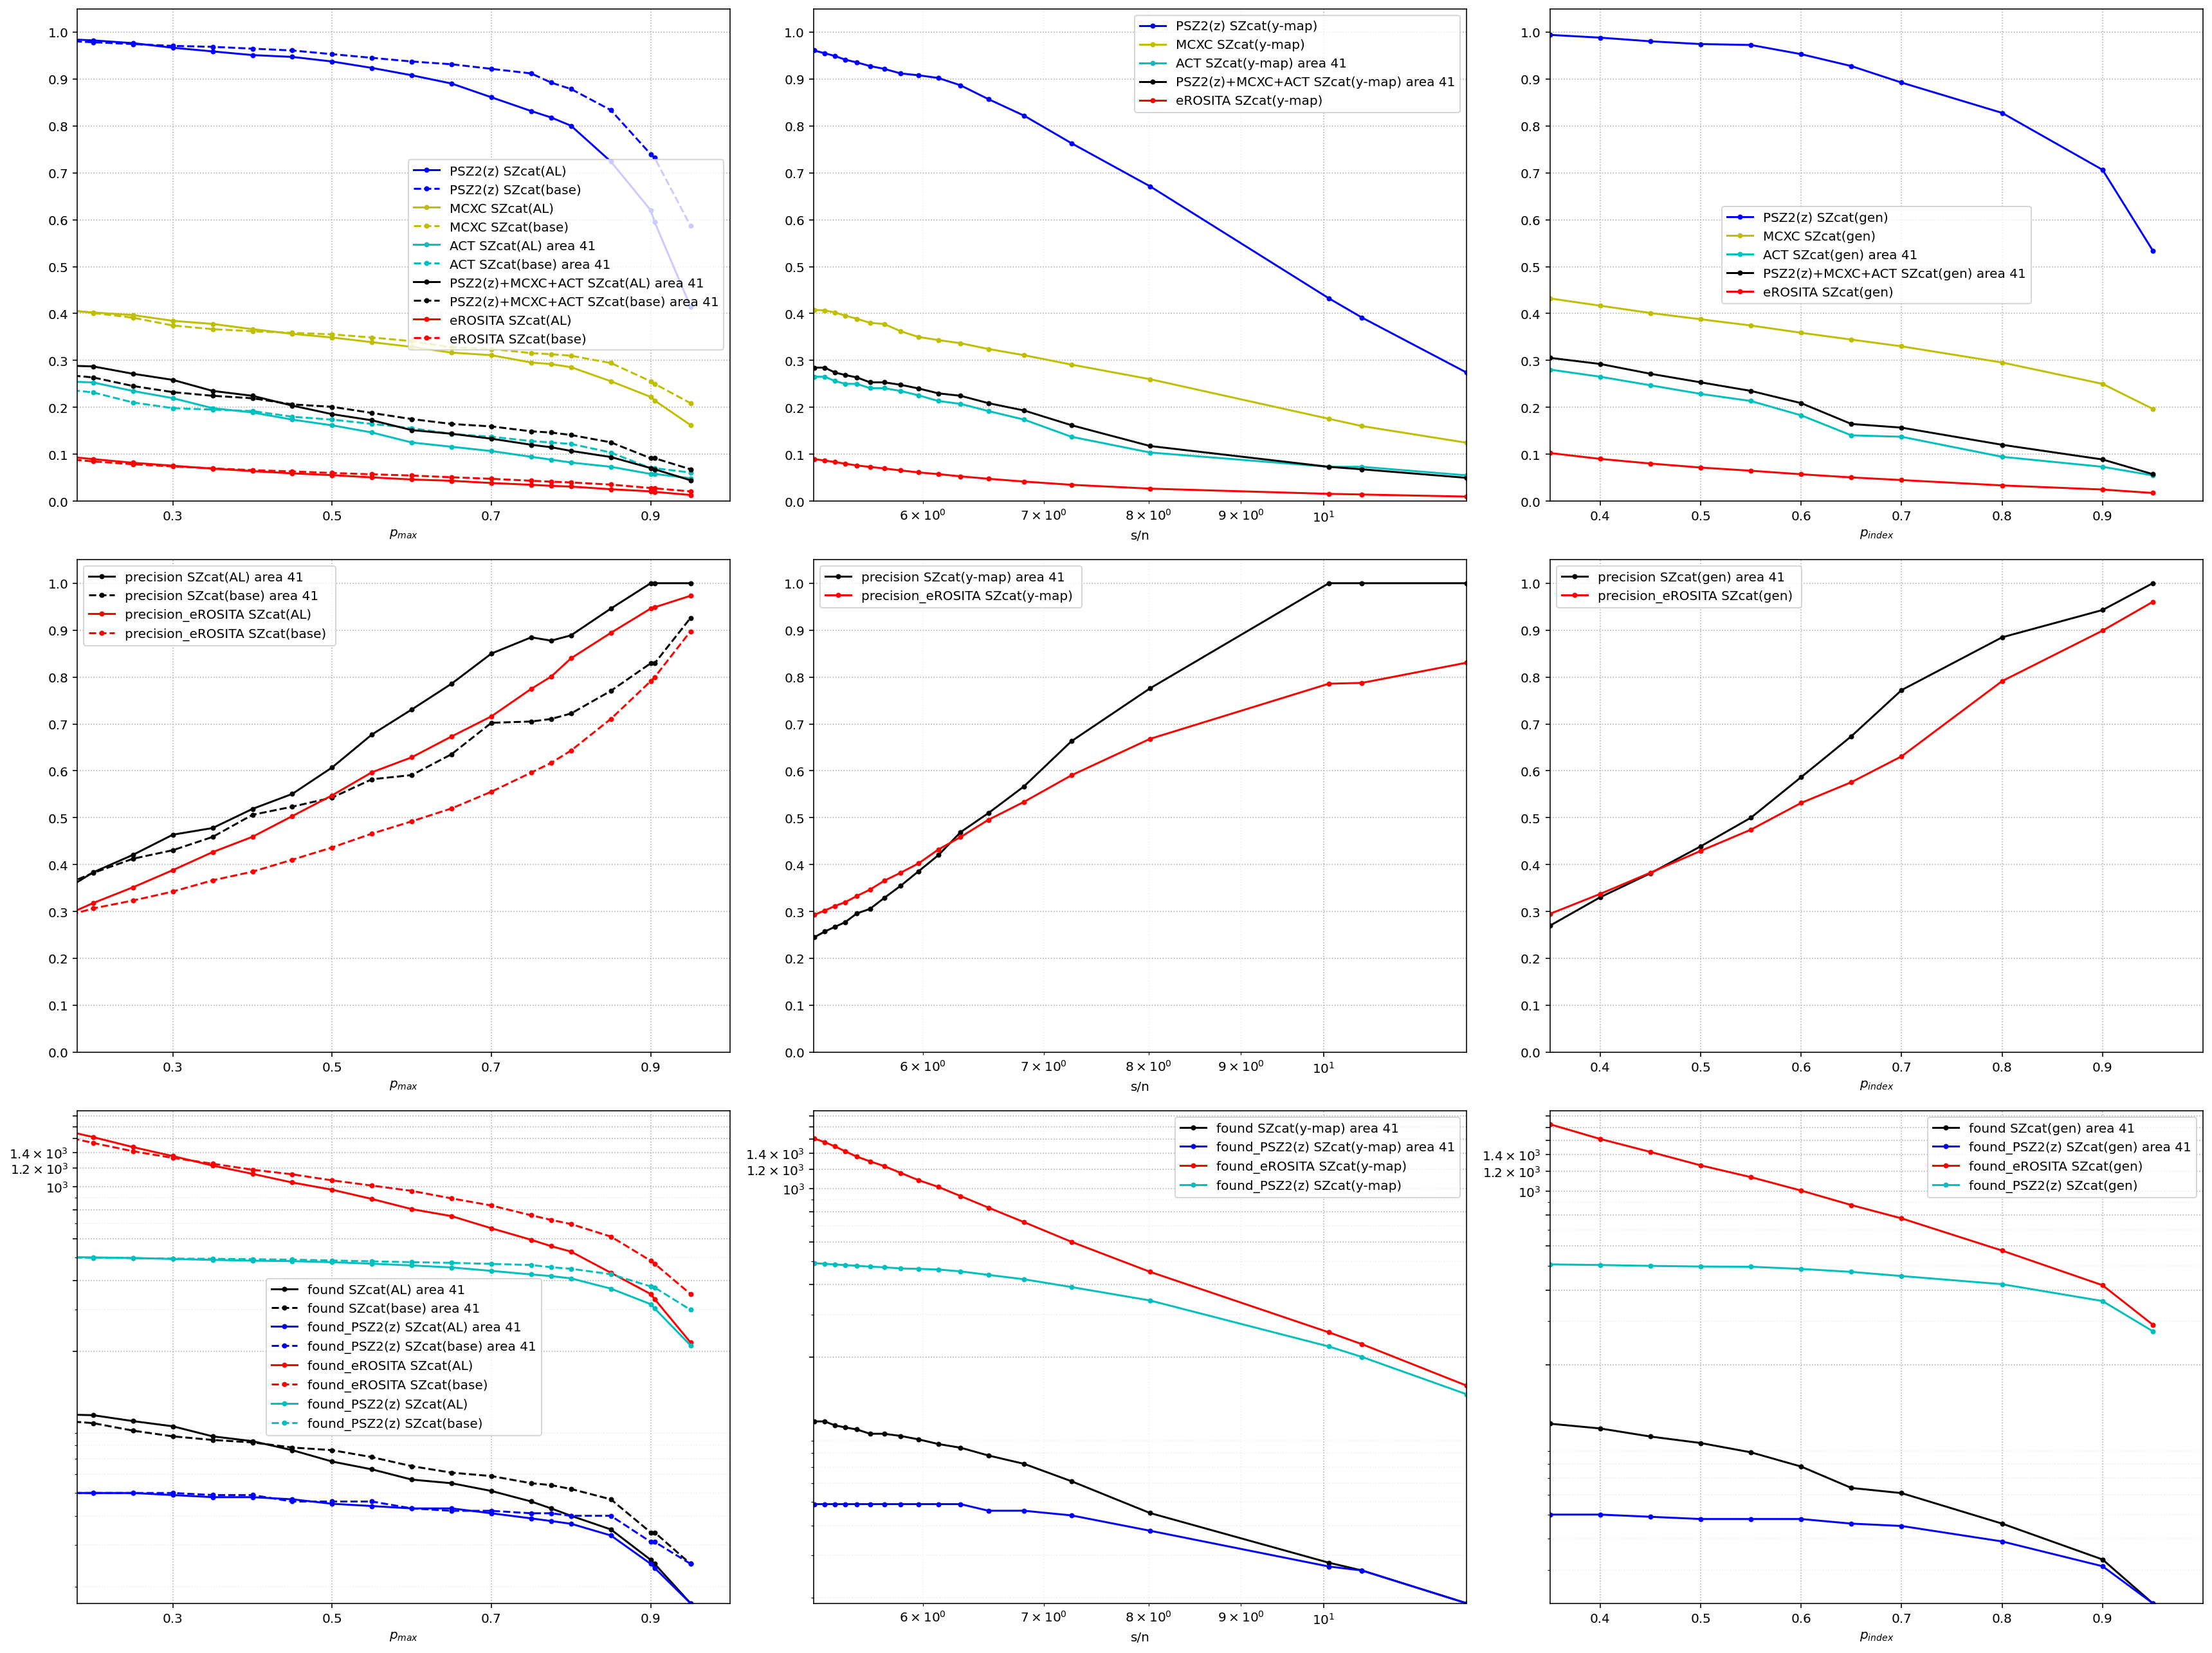

In [6]:
_, ax = plt.subplots(3, 3, figsize=(24, 18), sharey=False)
#plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

selected_det_list = (['SZcat(AL)', 'SZcat(base)'], ['SZcat(y-map)'], ['SZcat(gen)'])
xlim_list = ([0.18, 1.0], [5.22, 12], [0.35, 1.0])
xlogs = [False, True, False]
xlabels_list = ['$p_{max}$', None, '$p_{index}$']
xticks_list = [np.arange(0.1, 1, 0.1), None, np.arange(0, 1, 0.1)]
for i, (selected_det, xlim, xlog, xlabel, xticks) in enumerate(zip(selected_det_list, xlim_list, xlogs, xlabels_list, xticks_list)):
    #pixname_list=['41', 'eb20']
    #pixname_list=['41', '38']
    #pixname_list=['e', 'eb20']
    pixname_list=['eb20', '41', 'eb20']
    selected_tr_list = (['PSZ2(z)', 'MCXC'], ['ACT', 'all_true'], ['eROSITA'])
    colors_list = ['by', 'ck', 'r']
    for pixname, selected_tr, colors in zip(pixname_list, selected_tr_list, colors_list):
        show_prm(ax[0][i], pixname, selected_det, selected_tr, colors=colors, only_plot=False, xlim=xlim, xlog=xlog, 
                xlabel=xlabel, xticks=xticks)
    
    pixname_list = ['41', 'eb20']
    selected_tr_list = (['precision'], ['precision_eROSITA'])
    colors_list = ['kb', 'rc']
    for pixname, selected_tr, colors in zip(pixname_list, selected_tr_list, colors_list):
        show_prm(ax[1][i], pixname, selected_det, selected_tr, colors=colors, only_plot=False, xlim=xlim, xlog=xlog, 
                xlabel=xlabel, xticks=xticks)
        
    selected_tr_list = (['found', 'found_PSZ2(z)'], ['found_eROSITA', 'found_PSZ2(z)'])
    #coefs_list = [1, b20_coef]
    #coefs_list = [1, 1]
    #coefs_list = [1/2, b20_coef]
    coefs_list = [1, 1]
    fylim=[0, 2100]
    fyticks = fylim + [200]
    ylog=True
    
    
    
    for pixname, selected_tr, colors, coef in zip(pixname_list, selected_tr_list, colors_list, coefs_list):
        show_prm(ax[2][i], pixname, selected_det, selected_tr, colors=colors, only_plot=False, xlim=xlim, xlog=xlog, 
                 found_mode=True, coef=coef, fylim=fylim, fyticks=fyticks, ylog=ylog, 
                xlabel=xlabel, xticks=xticks)

plt.tight_layout()

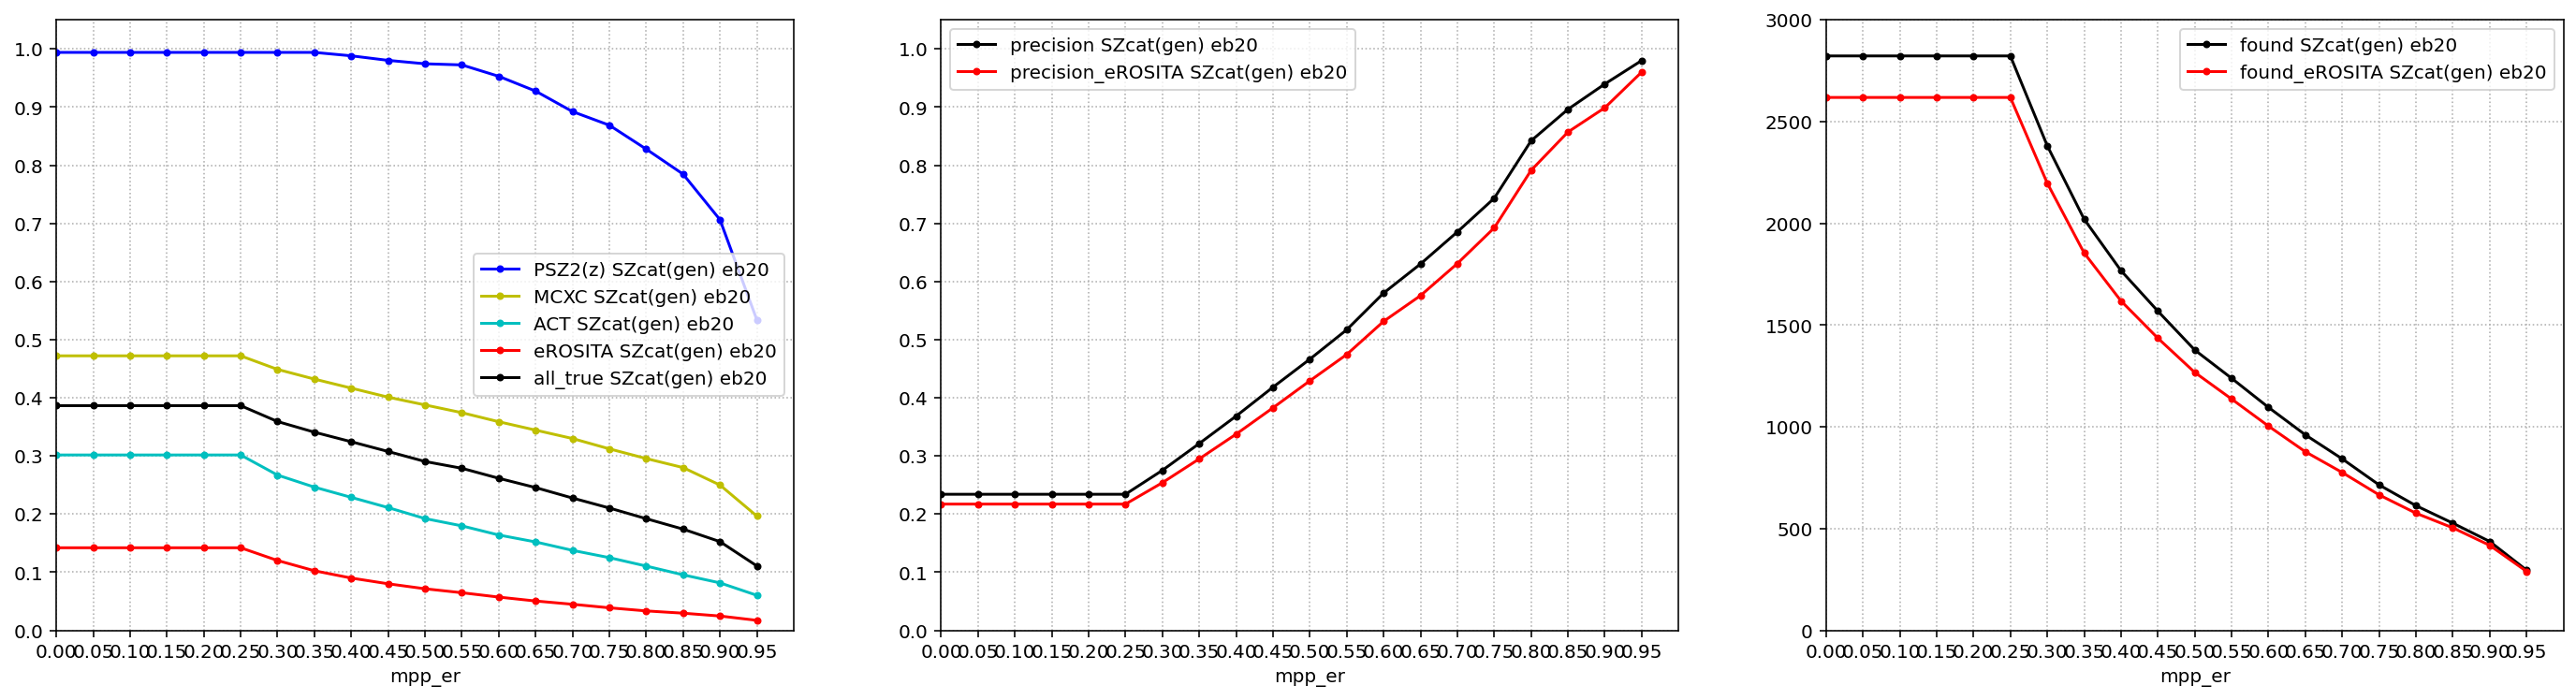

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(8 * 3, 6))
show_prm(ax[0], 'eb20', ['SZcat(gen)'], ['PSZ2(z)', 'MCXC', 'ACT', 'eROSITA', 'all_true'], index_name='mpp_er', colors='bycrk')
show_prm(ax[1], 'eb20', ['SZcat(gen)'], ['precision', 'precision_eROSITA'], index_name='mpp_er', colors='kr')
show_prm(ax[2], 'eb20', ['SZcat(gen)'], ['found', 'found_eROSITA'], index_name='mpp_er', colors='kr', fylim=[0, 3000], found_mode=True,
        fyticks=[0, 3100, 500])